In [1]:
import rasterio as rio
from rasterio.windows import Window
from rasterio.windows import from_bounds
from rasterio.enums import Resampling


import time
import os, glob
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
numTrys = 128
patchsize = 256
tempdir = "./tmp"
os.makedirs(tempdir,exist_ok=True)

# Loading from the default .jp2 files
All bands stored in seperate files and upsampling takes place during loading.

This is default methode without any preprocessing or change of data format.

In [3]:
def get_S2_locations(s2_dir):
    
    # get S2 image
    s2_b01 = glob.glob(os.path.join(s2_dir,"**","*B01_60m.jp2"),recursive=True)
    s2_b02 = glob.glob(os.path.join(s2_dir,"**","*B02_10m.jp2"),recursive=True)
    s2_b03 = glob.glob(os.path.join(s2_dir,"**","*B03_10m.jp2"),recursive=True)
    s2_b04 = glob.glob(os.path.join(s2_dir,"**","*B04_10m.jp2"),recursive=True)
    s2_b05 = glob.glob(os.path.join(s2_dir,"**","*B05_20m.jp2"),recursive=True)
    s2_b06 = glob.glob(os.path.join(s2_dir,"**","*B06_20m.jp2"),recursive=True)
    s2_b07 = glob.glob(os.path.join(s2_dir,"**","*B07_20m.jp2"),recursive=True)
    s2_b08 = glob.glob(os.path.join(s2_dir,"**","*B08_10m.jp2"),recursive=True)
    s2_b8a = glob.glob(os.path.join(s2_dir,"**","*B8A_20m.jp2"),recursive=True)
    s2_b09 = glob.glob(os.path.join(s2_dir,"**","*B09_60m.jp2"),recursive=True)
    s2_b11 = glob.glob(os.path.join(s2_dir,"**","*B11_20m.jp2"),recursive=True)
    s2_b12 = glob.glob(os.path.join(s2_dir,"**","*B12_20m.jp2"),recursive=True)

    s2_b01 = s2_b01[0]
    s2_b02 = s2_b02[0]
    s2_b03 = s2_b03[0]
    s2_b04 = s2_b04[0]
    s2_b05 = s2_b05[0]
    s2_b06 = s2_b06[0]
    s2_b07 = s2_b07[0]
    s2_b08 = s2_b08[0]
    s2_b8a = s2_b8a[0]
    s2_b09 = s2_b09[0]
    s2_b11 = s2_b11[0]
    s2_b12 = s2_b12[0]
    
    return {"b01":s2_b01,"b02":s2_b02,"b03":s2_b03,"b04":s2_b04,"b05":s2_b05,
            "b06":s2_b06,"b07":s2_b07,"b08":s2_b08,"b8a":s2_b8a,"b09":s2_b09,
            "b11":s2_b11,"b12":s2_b12}

In [4]:
locs_raw = get_S2_locations("./S2B_MSIL2A_20230928T101719_N0509_R065_T32UPU_20230928T145710.SAFE/")
locs_raw

{'b01': './S2B_MSIL2A_20230928T101719_N0509_R065_T32UPU_20230928T145710.SAFE/GRANULE/L2A_T32UPU_A034268_20230928T102123/IMG_DATA/R60m/T32UPU_20230928T101719_B01_60m.jp2',
 'b02': './S2B_MSIL2A_20230928T101719_N0509_R065_T32UPU_20230928T145710.SAFE/GRANULE/L2A_T32UPU_A034268_20230928T102123/IMG_DATA/R10m/T32UPU_20230928T101719_B02_10m.jp2',
 'b03': './S2B_MSIL2A_20230928T101719_N0509_R065_T32UPU_20230928T145710.SAFE/GRANULE/L2A_T32UPU_A034268_20230928T102123/IMG_DATA/R10m/T32UPU_20230928T101719_B03_10m.jp2',
 'b04': './S2B_MSIL2A_20230928T101719_N0509_R065_T32UPU_20230928T145710.SAFE/GRANULE/L2A_T32UPU_A034268_20230928T102123/IMG_DATA/R10m/T32UPU_20230928T101719_B04_10m.jp2',
 'b05': './S2B_MSIL2A_20230928T101719_N0509_R065_T32UPU_20230928T145710.SAFE/GRANULE/L2A_T32UPU_A034268_20230928T102123/IMG_DATA/R20m/T32UPU_20230928T101719_B05_20m.jp2',
 'b06': './S2B_MSIL2A_20230928T101719_N0509_R065_T32UPU_20230928T145710.SAFE/GRANULE/L2A_T32UPU_A034268_20230928T102123/IMG_DATA/R20m/T32UPU_2023

In [5]:
times = []

# get the bounds of the raster
with rio.open(locs_raw["b02"],"r") as src:
    bounds = src.bounds
    transform = src.transform

# load N random windows
for i in range(numTrys):
    
    x0,y0 = np.random.randint(0,10980-patchsize,2)
    new_left = bounds.left + x0*10
    new_bottom = bounds.bottom + y0*10  
    
    t0 = time.time()
    
    tensor = []
    for band in locs_raw.keys():
        with rio.open(locs_raw[band],"r") as src:
            
            win = from_bounds(new_left,new_bottom,new_left+patchsize*10,new_bottom+patchsize*10,src.transform)
            
            if band in ["b02","b03","b04","b08"]:
                tensor.append( src.read(1, window=win) )
                
            else:
                tensor.append( src.read(1, window=win, out_shape=(1,patchsize,patchsize), resampling=Resampling.cubic) )
    
    tensor = np.stack(tensor,axis=0)
    
    t1 = time.time()
    
    times.append(t1-t0)

In [6]:
np.mean(times)

0.3675338365137577

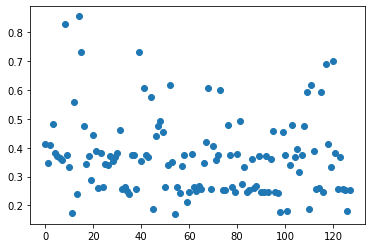

In [7]:
plt.scatter(range(len(times)),times)

# Make a geotiff with all data combined and load windows from there

### without tiling

In [8]:
tensor = []
for band in locs_raw.keys():
    with rio.open(locs_raw[band],"r") as src:

        if band in ["b02","b03","b04","b08"]:
            tensor.append( src.read(1) )
        else:
            tensor.append( src.read(1, out_shape=(1,10980,10980),resampling=Resampling.cubic) )

tensor = np.stack(tensor,axis=0)

In [9]:
tensor.shape

(12, 10980, 10980)

In [10]:
with rio.open(locs_raw["b02"],"r") as src:
    meta = src.meta
meta["driver"]="GTiff"
meta["count"]=12
meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 12,
 'crs': CRS.from_epsg(32632),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 5400000.0)}

In [11]:
with rio.open(os.path.join(tempdir,"S2cube.tif"),"w",**meta) as dst:
    dst.write(tensor)

In [12]:
times = []

# get the bounds of the raster
with rio.open(os.path.join(tempdir,"S2cube.tif"),"r") as src:
    bounds = src.bounds
    transform = src.transform

# load N random windows
for i in range(numTrys):
    
    x0,y0 = np.random.randint(0,10980-patchsize,2)
    new_left = bounds.left + x0*10
    new_bottom = bounds.bottom + y0*10  
    
    t0 = time.time()

    with rio.open(os.path.join(tempdir,"S2cube.tif"),"r") as src:

        win = from_bounds(new_left,new_bottom,new_left+patchsize*10,new_bottom+patchsize*10,src.transform)

        tensor = src.read(window=win)

    t1 = time.time()
    
    times.append(t1-t0)

In [13]:
np.mean(times)

0.048505859449505806

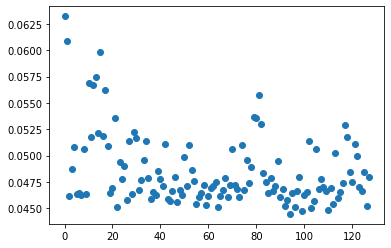

In [14]:
plt.scatter(range(len(times)),times)

### try with the tiled == True

In [15]:
with rio.open(locs_raw["b02"],"r") as src:
    meta = src.meta
meta["driver"]="GTiff"
meta["count"]=12
meta["tiled"]=True
meta["blocksize"]=256

with rio.open(os.path.join(tempdir,"S2cubeTiled.tif"),"w",**meta) as dst:
    dst.write(tensor)

In [16]:
times = []

# get the bounds of the raster
with rio.open(os.path.join(tempdir,"S2cubeTiled.tif"),"r") as src:
    bounds = src.bounds
    transform = src.transform

# load N random windows
for i in range(numTrys):
    
    x0,y0 = np.random.randint(0,10980-patchsize,2)
    new_left = bounds.left + x0*10
    new_bottom = bounds.bottom + y0*10  
    
    t0 = time.time()

    with rio.open(os.path.join(tempdir,"S2cubeTiled.tif"),"r") as src:

        win = from_bounds(new_left,new_bottom,new_left+patchsize*10,new_bottom+patchsize*10,src.transform)

        tensor = src.read(window=win)

    t1 = time.time()
    
    times.append(t1-t0)

In [17]:
np.mean(times)

0.004990484565496445

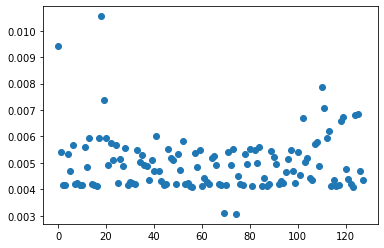

In [18]:
plt.scatter(range(len(times)),times)

### try with compression

In [28]:
with rio.open(locs_raw["b02"],"r") as src:
    meta = src.meta
meta["driver"]="GTiff"
meta["count"]=12
meta["tiled"]=True
meta["blocksize"]=256
meta["compress"] = "LZW"

with rio.open(os.path.join(tempdir,"S2cubeTiledCompressed.tif"),"w",**meta) as dst:
    dst.write(tensor)

In [29]:
times = []

# get the bounds of the raster
with rio.open(os.path.join(tempdir,"S2cubeTiledCompressed.tif"),"r") as src:
    bounds = src.bounds
    transform = src.transform

# load N random windows
for i in range(numTrys):
    
    x0,y0 = np.random.randint(0,10980-patchsize,2)
    new_left = bounds.left + x0*10
    new_bottom = bounds.bottom + y0*10  
    
    t0 = time.time()

    with rio.open(os.path.join(tempdir,"S2cubeTiledCompressed.tif"),"r") as src:

        win = from_bounds(new_left,new_bottom,new_left+patchsize*10,new_bottom+patchsize*10,src.transform)

        tensor = src.read(window=win)

    t1 = time.time()
    
    times.append(t1-t0)

In [30]:
np.mean(times)

0.01619572378695011

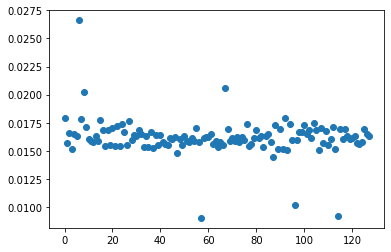

In [31]:
plt.scatter(range(len(times)),times)

### find the best tiling blocksize

In [23]:
for BS in [128,256,512,1024,2048,4096]:
    
    with rio.open(locs_raw["b02"],"r") as src:
        meta = src.meta
    meta["driver"]="GTiff"
    meta["count"]=12
    meta["tiled"]=True
    meta["blocksize"]=BS

    with rio.open(os.path.join(tempdir,"S2cubeTiled.tif"),"w",**meta) as dst:
        dst.write(tensor)
        
        
    times = []

    # get the bounds of the raster
    with rio.open(os.path.join(tempdir,"S2cubeTiled.tif"),"r") as src:
        bounds = src.bounds
        transform = src.transform

    # load N random windows
    for i in range(numTrys):

        x0,y0 = np.random.randint(0,10980-patchsize,2)
        new_left = bounds.left + x0*10
        new_bottom = bounds.bottom + y0*10  

        t0 = time.time()

        with rio.open(os.path.join(tempdir,"S2cubeTiled.tif"),"r") as src:

            win = from_bounds(new_left,new_bottom,new_left+patchsize*10,new_bottom+patchsize*10,src.transform)

            tensor = src.read(window=win)

        t1 = time.time()

        times.append(t1-t0)
        
    print(BS,np.mean(times))

128 0.004993639886379242
256 0.004993157461285591
512 0.00489007867872715
1024 0.004664447158575058
2048 0.004816526547074318
4096 0.004867414012551308


# loading patches from hdf5 file

### generate data

In [24]:
# get the bounds of the raster
with rio.open(os.path.join(tempdir,"S2cubeTiled.tif"),"r") as src:
    bounds = src.bounds
    transform = src.transform

locs = []

with h5py.File(os.path.join(tempdir,'S2patches.h5'), 'w') as hdf:
    # load N random windows
    for i in range(5000):
        x0,y0 = np.random.randint(0,10980-patchsize,2)
        new_left = bounds.left + x0*10
        new_bottom = bounds.bottom + y0*10  
        with rio.open(os.path.join(tempdir,"S2cubeTiled.tif"),"r") as src:
            win = from_bounds(new_left,new_bottom,new_left+patchsize*10,new_bottom+patchsize*10,src.transform)
            tensor = src.read(window=win)
            hdf.create_dataset(f'dataset_{i}', data=tensor)

### perform read

In [25]:
times = []

# load N random windows
for i in range(numTrys):

    j = np.random.randint(0,5000)

    t0 = time.time()
    
    with h5py.File(os.path.join(tempdir,'S2patches.h5'), 'r') as hdf:
        data = hdf[f'dataset_{j}'][:]

    t1 = time.time()

    times.append(t1-t0)

In [26]:
np.mean(times)

0.0009703878313302994

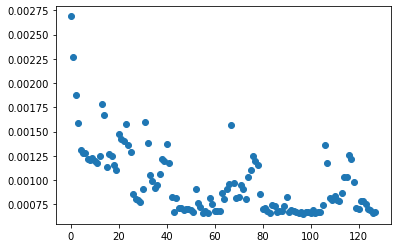

In [27]:
plt.scatter(range(len(times)),times)